## Tutorial for 2D acoustic with pressure-velocity equations with CG

This tutorial focuses on the implementation on the 2D acoustic wave using pressure-velocity formulation:
$$p\frac{\partial v}{\partial t} + \nabla p = f$$
$$\frac{1}{\rho c^2} \frac{\partial p}{\partial t} + \nabla \cdot v = g $$
In order to simplify the problem we assume $\rho = 1$ and $c = 1$ as constants.

To arrive at a weak formulation we can seperate $u$ into $u_x$ and $u_y$ (arriving at three equations and multiply each by test functions $q_1$, $q_2$ and $q_3$.
$$\int_{\Omega} \frac{1}{c^2} \frac{\partial p}{\partial t}q_1d\vec{x} 
 -\int_{\Omega} (u_x \frac{\partial q_1}{\partial x} + u_y \frac{\partial q_1}{\partial y})d\vec{x} = 
 \int_{\Omega}gq_1d\vec{x}$$
 
$$\int_{\Omega} \frac{\partial u_x}{\partial t}q_2d\vec{x} 
  - \int_{\Omega} p\frac{\partial q_2}{\partial x}d\vec{x} = 0 $$
  
$$\int_{\Omega} \frac{\partial u_y}{\partial t}q_3d\vec{x} 
  - \int_{\Omega} p\frac{\partial q_3}{\partial y}d\vec{x} = 0 $$


# Solving the forward problem in Firedrake
Use the folowing to plot inside the jupyter notebook

In [1]:
%matplotlib notebook

Calling all libraries

In [2]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
from tsfc import compile_form
set_log_level(ERROR)

In [3]:
import FIAT, finat

def gauss_lobatto_legendre_line_rule(degree):
    fiat_make_rule = FIAT.quadrature.GaussLobattoLegendreQuadratureLineRule
    fiat_rule = fiat_make_rule(FIAT.ufc_simplex(1), degree + 1)
    finat_ps = finat.point_set.GaussLobattoLegendrePointSet
    finat_qr = finat.quadrature.QuadratureRule
    return finat_qr(finat_ps(fiat_rule.get_points()), fiat_rule.get_weights())

def gll_rule(dimension, degree):
    make_tensor_rule = finat.quadrature.TensorProductQuadratureRule
    result = gauss_lobatto_legendre_line_rule(degree)
    for _ in range(1, dimension):
        line_rule = gauss_lobatto_legendre_line_rule(degree)
        result = make_tensor_rule([result, line_rule])
    return result

Let's specify our output file for visualization in Paraview

In [4]:
## Output file
output_file='output/VectorSpectral_convergence/Forward.pvd'
outfile = File(output_file)

Let's first define our h and p variables:

In [5]:
order=5
mesh_size =5

# Creating mesh
Now we can build our simple unit square mesh with triangular elements (if we want quads we just have to add quadrilateral = True to the UnitSquareMesh function)

In [6]:
mesh = UnitSquareMesh(mesh_size, mesh_size, quadrilateral = True)
x,y = SpatialCoordinate(mesh)

We can visualize our mesh with the plot command

<IPython.core.display.Javascript object>


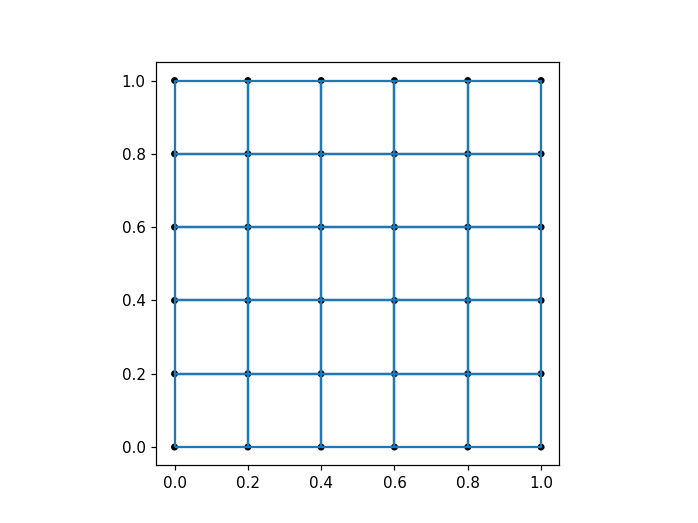

In [7]:
plot(mesh);

Since we are dealing with 3 spaces (for ux, uy, p) a simple FunctionSpace function isn't enough therefore we do:

In [8]:
CGOrder = FiniteElement('CG', quadrilateral, order, variant='spectral')
element = MixedElement([CGOrder, CGOrder, CGOrder])
V = FunctionSpace(mesh, element)

# Specifying source function and boundary conditions
In order to have an analytical function for comparison we can use the so called 'method of manufactured solution'. First we impose a solution and boundary conditions to our system of equations. Then we use that 'solution' to calculate our source term. 

Our solution is 
$$ p = t^2 sin( \pi x) sin (\pi y) $$

Which, after substituting on our original equations with Dirichlet Boundary conditions gives us:
$$ g = sin( \pi x) sin(\pi y) (2t + \frac{2 \pi ^2 t^3}{3} )$$

Since $g$ is time-dependent I will seperate it into a function of space times one of time and interpolate $gX = sin( \pi x) sin(\pi y)$ to our function space.

In [9]:
sourceX = Function(V.sub(2)).interpolate(sin(pi*x)*sin(pi*y))

Dirichlet contidions are easy to implement in Firedrake:

In [10]:
bcp = DirichletBC(V.sub(2),0.,"on_boundary")

Most dificulties can be solved by looking at the help file:

In [11]:
help(DirichletBC)

Help on class DirichletBC in module firedrake.bcs:

class DirichletBC(builtins.object)
 |  Implementation of a strong Dirichlet boundary condition.
 |  
 |  :arg V: the :class:`.FunctionSpace` on which the boundary condition
 |      should be applied.
 |  :arg g: the boundary condition values. This can be a :class:`.Function` on
 |      ``V``, a :class:`.Constant`, an :class:`.Expression`, an
 |      iterable of literal constants (converted to an
 |      :class:`.Expression`), or a literal constant which can be
 |      pointwise evaluated at the nodes of
 |      ``V``. :class:`.Expression`\s are projected onto ``V`` if it
 |      does not support pointwise evaluation.
 |  :arg sub_domain: the integer id(s) of the boundary region over which the
 |      boundary condition should be applied. The string "on_boundary" may be used
 |      to indicate all of the boundaries of the domain. In the case of extrusion
 |      the ``top`` and ``bottom`` strings are used to flag the bcs application o

Defining our variables for integration in time:

In [12]:
q = 0.001 #Courant number
T = 0.1 #Final time
dt_stable = q/(mesh_size)
ite = 1+int(T/dt_stable)
dt = T/float(ite)
h = dt
dtc = Constant(dt)

t = 0.0
t_sim = t
step = 0

In [13]:
(qx, qy, q) = TestFunctions(V)
initial = Function(V.sub(0)).interpolate(0.*x*y)

UP = Function(V)
ux, uy, p   = UP.split()
ux.assign(initial)
uy.interpolate(initial)
p.interpolate(initial)

UP_prev = Function(V)
ux_prev, uy_prev, p_prev = UP_prev.split()
ux_prev.interpolate(pi*dt*dt*dt/3. * cos(pi*x)*sin(pi*y) )
uy_prev.interpolate(pi*dt*dt*dt/3. * sin(pi*x)*cos(pi*y) )
p_prev.interpolate( dt*dt          * sin(pi*x)*sin(pi*y))

UP_fut = Function(V)
ux_fut, uy_fut, p_fut = UP_fut.split()
ux_fut.assign(ux)
uy_fut.assign(uy)
p_fut.assign(p)

The partial derivatives were implemented as trial functions, making it easies to implement other time integration methods such as Runge-Kutta

In [14]:
dUP = Function(V)
dux, duy, dp = dUP.split()
K1 = Function(V)
K2 = Function(V)
K3 = Function(V)
K4 = Function(V)

dux_trial, duy_trial, dp_trial = TrialFunctions(V)

params = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}

runtime=0.

Solving our problem

In [15]:
for i in range(1,(ite)):
    t   = dt*i
              
    t1  = t
    Ct1 = Constant(t1)
    LHS = (dp_trial)*q*dx(rule=gll_rule(2,order)) + dux_trial*qx*dx(rule=gll_rule(2,order)) + duy_trial*qy*dx(rule=gll_rule(2,order))
    RHS = ((ux*q.dx(0) + uy*q.dx(1))*dx(rule=gll_rule(2,order)) + sourceX*(2*Ct1+2*pi**2*Ct1**3/3.)*q*dx(rule=gll_rule(2,order))) + \
            p*qx.dx(0)*dx(rule=gll_rule(2,order)) + \
            p*qy.dx(1)*dx(rule=gll_rule(2,order))

    solve(LHS == RHS, dUP, bcp) #Solve for du and dp
    K1.assign(dUP)
    d1UX, d1UY, d1P = K1.split()

    # Updating answer
    ux_fut.assign(ux_prev + 2.*dt*d1UX)
    uy_fut.assign(uy_prev + 2.*dt*d1UY)
    p_fut.assign( p_prev  + 2.*dt*d1P)

    ux_prev.assign(ux)
    uy_prev.assign(uy)
    p_prev.assign(p) 

    ux.assign(ux_fut)
    uy.assign(uy_fut)
    p.assign( p_fut)

    ux_fut.assign(ux_prev + 2.*dt*d1UX)
    uy_fut.assign(uy_prev + 2.*dt*d1UY)
    p_fut.assign( p_prev  + 2.*dt*d1P)

We can plot our solution using a simple plot command. Note that when using higher-order nodal functions we have to specify the number of sampling points per element in the plot function.

<IPython.core.display.Javascript object>


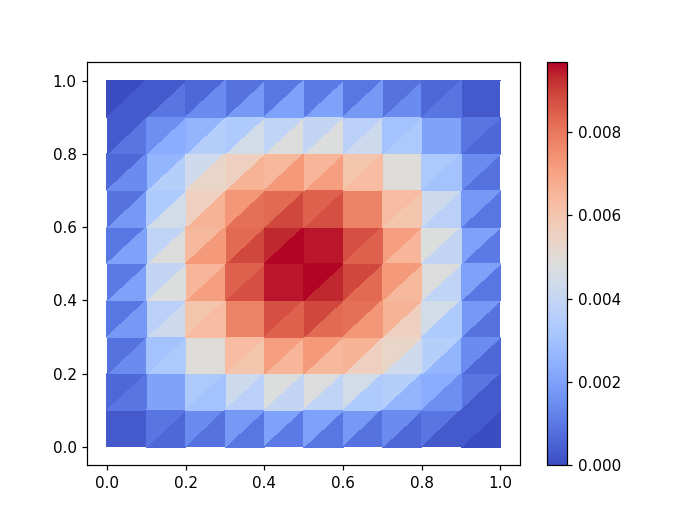

In [16]:
plot(p);

In [17]:
t_sim = t + dt
print("\t final time = ",t_sim)
p_init  = Function(V.sub(2)).interpolate((t_sim**2)*sin(pi*x)*sin(pi*y))            
L2_err  = sqrt(assemble((p - p_init)*(p - p_init)*dx))
L2 = L2_err
print("\t L2 Error = ",L2)

	 final time =  0.10000000000000002
	 L2 Error =  1.7345572027467003e-08


We can also plot the analytical solution

<IPython.core.display.Javascript object>


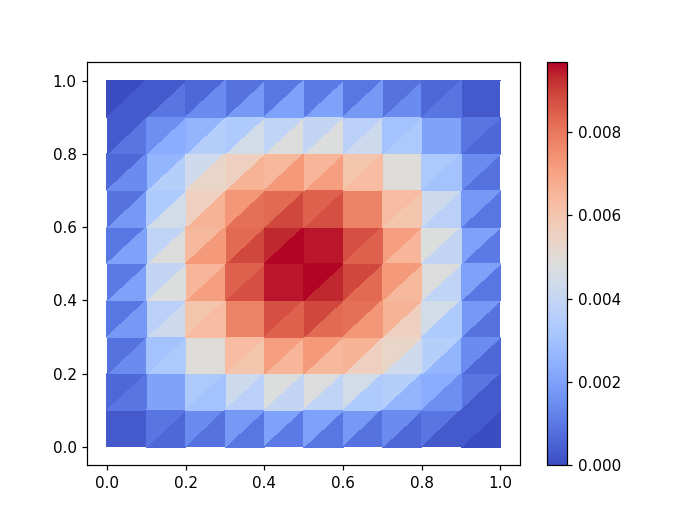

In [18]:
plot(p_init);